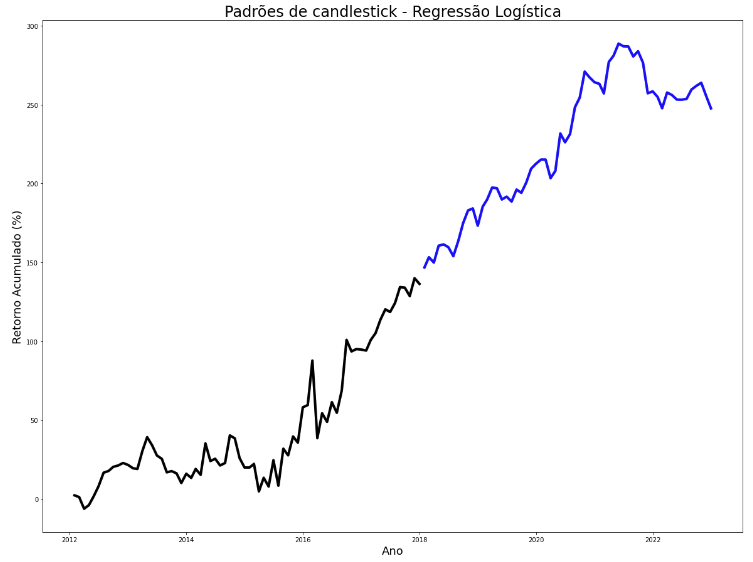

In [161]:
import numpy as np
import pandas as pd
import scipy.stats

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import talib
from numpy import mean, absolute
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [162]:
# Get the data

p1 = 252

ticker1 = "PETR4.SA" 
df1 = yf.download(ticker1, "2012-01-01", "2022-12-31")
df1["Retornos"] = df1["Adj Close"].pct_change(1)
df1["Adj Low"] = df1["Low"] - (df1["Close"]-df1["Adj Close"])
df1["Adj High"] = df1["High"] - (df1["Close"]-df1["Adj Close"])
df1["Adj Open"] = df1["Open"] - (df1["Close"]-df1["Adj Close"])
df1.dropna(axis = 0, inplace = True) 
df1.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Retornos,Adj Low,Adj High,Adj Open
Date,,,,,,,,,,
2012-01-03,21.830000,22.410000,21.809999,22.410000,8.947165,22940500,0.039777,8.347165,8.947165,8.367166
2012-01-04,22.180000,22.580000,21.980000,22.570000,9.011046,18736900,0.007140,8.421046,9.021047,8.621047
2012-01-05,22.389999,22.610001,22.150000,22.309999,8.907240,19489000,-0.011520,8.747240,9.207241,8.987240
2012-01-06,22.469999,22.580000,22.250000,22.330000,8.915225,13941000,0.000896,8.835225,9.165225,9.055224
2012-01-09,22.440001,22.629999,22.280001,22.629999,9.035001,14665100,0.013435,8.685002,9.035001,8.845002


In [163]:
# Construção do alvo

# Alvo 1 - Retornos
df1["Alvo1"] = df1["Retornos"].shift(-1)

# Criação do alvo categórico
df1["Alvo1_cat"] = np.where(df1["Alvo1"] > 0 , 1, 0)

In [164]:
# Conhecendo a TA-lib
# Visualiza todas as funções disponíveis como uma lista


print(talib.get_functions())

['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR',

In [165]:
# Visualiza o dicionário de funções de uma maneira mais "humana"

import json

print(json.dumps(talib.get_function_groups(), sort_keys = True, indent = 4))

{
    "Cycle Indicators": [
        "HT_DCPERIOD",
        "HT_DCPHASE",
        "HT_PHASOR",
        "HT_SINE",
        "HT_TRENDMODE"
    ],
    "Math Operators": [
        "ADD",
        "DIV",
        "MAX",
        "MAXINDEX",
        "MIN",
        "MININDEX",
        "MINMAX",
        "MINMAXINDEX",
        "MULT",
        "SUB",
        "SUM"
    ],
    "Math Transform": [
        "ACOS",
        "ASIN",
        "ATAN",
        "CEIL",
        "COS",
        "COSH",
        "EXP",
        "FLOOR",
        "LN",
        "LOG10",
        "SIN",
        "SINH",
        "SQRT",
        "TAN",
        "TANH"
    ],
    "Momentum Indicators": [
        "ADX",
        "ADXR",
        "APO",
        "AROON",
        "AROONOSC",
        "BOP",
        "CCI",
        "CMO",
        "DX",
        "MACD",
        "MACDEXT",
        "MACDFIX",
        "MFI",
        "MINUS_DI",
        "MINUS_DM",
        "MOM",
        "PLUS_DI",
        "PLUS_DM",
        "PPO",
        "ROC",
        "RO

In [166]:
# Insigths práticos

df1["doji_star"] = talib.CDLDOJISTAR(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["doji_star"] = np.where(df1["doji_star"] == 100, 1
                            , np.where(df1["doji_star"] == -100, -1, 0))
doji = pd.pivot_table(df1
               , index = ["doji_star"]
               , values = ["Alvo1"]
               , aggfunc = np.mean)*100
doji

,Alvo1
doji_star,
-1,0.479708
0,0.080430
1,-0.207627


In [167]:
doji_cat = pd.pivot_table(df1
               , index = ["doji_star"]
               , values = ["Alvo1_cat"]
               , aggfunc = np.mean)*100
doji_cat

,Alvo1_cat
doji_star,
-1,53.333333
0,50.637659
1,45.454545


In [168]:
df1["marubozu"] = talib.CDLCLOSINGMARUBOZU(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["marubozu"] = np.where(df1["marubozu"] == 100, 1
                            , np.where(df1["marubozu"] == -100, -1, 0))

marubozu = pd.pivot_table(df1
               , index = ["marubozu"]
               , values = ["Alvo1"]
               , aggfunc = np.mean)*100
marubozu

,Alvo1
marubozu,
-1,0.317259
0,0.064507
1,-0.010024


In [169]:
marubozu_cat = pd.pivot_table(df1
               , index = ["marubozu"]
               , values = ["Alvo1_cat"]
               , aggfunc = np.mean)*100
marubozu_cat

,Alvo1_cat
marubozu,
-1,58.203125
0,50.088889
1,47.169811


In [170]:
df1["harami"] = talib.CDLHARAMI(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["harami"] = np.where(df1["harami"] == 100, 1
                            , np.where(df1["harami"] == -100, -1, 0))
harami = pd.pivot_table(df1
               , index = ["harami"]
               , values = ["Alvo1"]
               , aggfunc = np.mean)*100
harami

,Alvo1
harami,
-1,-0.123714
0,0.064086
1,0.542325


In [171]:
harami_cat = pd.pivot_table(df1
               , index = ["harami"]
               , values = ["Alvo1_cat"]
               , aggfunc = np.mean)*100
harami_cat

,Alvo1_cat
harami,
-1,48.387097
0,50.613376
1,51.937984


In [172]:
df1["engolfo"] = talib.CDLENGULFING(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["engolfo"] = np.where(df1["engolfo"] == 100, 1
                            , np.where(df1["engolfo"] == -100, -1, 0))

In [173]:
engolfo = pd.pivot_table(df1
               , index = ["engolfo"]
               , values = ["Alvo1"]
               , aggfunc = np.mean)*100
engolfo

,Alvo1
engolfo,
-1,0.106580
0,0.100234
1,-0.222163


In [174]:
engolfo_cat = pd.pivot_table(df1
               , index = ["engolfo"]
               , values = ["Alvo1_cat"]
               , aggfunc = np.mean)*100
engolfo_cat

,Alvo1_cat
engolfo,
-1,55.191257
0,50.797649
1,42.483660


In [175]:
df1["martelo"] = talib.CDLHAMMER(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["martelo"] = np.where(df1["martelo"] == 100, 1
                            , np.where(df1["martelo"] == -100, -1, 0))
martelo = pd.pivot_table(df1
               , index = ["martelo"]
               , values = ["Alvo1"]
               , aggfunc = np.mean)*100
martelo

,Alvo1
martelo,
0,0.075957
1,0.323106


In [176]:
martelo_cat = pd.pivot_table(df1
               , index = ["martelo"]
               , values = ["Alvo1_cat"]
               , aggfunc = np.mean)*100
martelo_cat

,Alvo1_cat
martelo,
0,50.529101
1,54.166667


In [177]:
print(doji)
print("------------------------------------------")
print(marubozu)
print("------------------------------------------")
print(harami)
print("------------------------------------------")
print(engolfo)
print("------------------------------------------")
print(martelo)

              Alvo1
doji_star          
-1         0.479708
 0         0.080430
 1        -0.207627
------------------------------------------
             Alvo1
marubozu          
-1        0.317259
 0        0.064507
 1       -0.010024
------------------------------------------
           Alvo1
harami          
-1     -0.123714
 0      0.064086
 1      0.542325
------------------------------------------
            Alvo1
engolfo          
-1       0.106580
 0       0.100234
 1      -0.222163
------------------------------------------
            Alvo1
martelo          
0        0.075957
1        0.323106


In [178]:
fig = px.scatter(x = df1[df1["doji_star"] != 0]["Retornos"]*100
                 , y = df1[df1["doji_star"] != 0]["Alvo1"]*100 , trendline = "ols")

fig.update_layout(height = 600, width = 700
                  , title_text = "Relação entre uma Doji e o Alvo em 1 período"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Retornos da Doji"
                  , yaxis_title = "Alvo 1"
                  , font = dict(size = 15, color = "Black")
                  , showlegend = True
                 )

fig.show()


In [179]:
fig = px.scatter(x = df1[df1["marubozu"] != 0]["Retornos"]*100
                 , y = df1[df1["marubozu"] != 0]["Alvo1"]*100 , trendline = "ols")

fig.update_layout(height = 600, width = 700
                  , title_text = "Relação entre um marubozu e o Alvo em 1 período"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Retornos do marubozu"
                  , yaxis_title = "Alvo 1"
                  , font = dict(size = 15, color = "Black")
                  , showlegend = True
                 )

fig.show()


In [180]:
fig = px.scatter(x = df1[df1["harami"] != 0]["Retornos"]*100
                 , y = df1[df1["harami"] != 0]["Alvo1"]*100 , trendline = "ols")

fig.update_layout(height = 600, width = 700
                  , title_text = "Relação entre um harami e o Alvo em 1 período"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Retornos do harami"
                  , yaxis_title = "Alvo 1"
                  , font = dict(size = 15, color = "Black")
                  , showlegend = True
                 )

fig.show()


In [181]:
fig = px.scatter(x = df1[df1["engolfo"] != 0]["Retornos"]*100
                 , y = df1[df1["engolfo"] != 0]["Alvo1"]*100 , trendline = "ols")

fig.update_layout(height = 600, width = 700
                  , title_text = "Relação entre um engolfo e o Alvo em 1 período"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Retornos do engolfo"
                  , yaxis_title = "Alvo 1"
                  , font = dict(size = 15, color = "Black")
                  , showlegend = True
                 )

fig.show()


In [182]:
fig = px.scatter(x = df1[df1["martelo"] != 0]["Retornos"]*100
                 , y = df1[df1["martelo"] != 0]["Alvo1"]*100 , trendline = "ols")

fig.update_layout(height = 600, width = 700
                  , title_text = "Relação entre um martelo e o Alvo em 1 período"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Retornos do martelo"
                  , yaxis_title = "Alvo 1"
                  , font = dict(size = 15, color = "Black")
                  , showlegend = True
                 )

fig.show()


In [183]:
# Concatenação dos nossos 5 dataframes para modelagem
# Ou seja, é um modelo que seria aplicado quando e apenas se algum do padrões fosse identificado

df_doji = df1[df1["doji_star"] != 0]
df_doji.dropna(inplace = True)

df_harami = df1[df1["harami"] != 0]
df_harami.dropna(inplace = True)

df_marubozu = df1[df1["marubozu"] != 0]
df_marubozu.dropna(inplace = True)

df_engolfo = df1[df1["engolfo"] != 0]
df_engolfo.dropna(inplace = True)

df_martelo = df1[df1["martelo"] != 0]
df_martelo.dropna(inplace = True)

df_padroes = pd.concat([df_doji, df_harami, df_marubozu, df_engolfo, df_martelo]) # se for remover ou adicionar, faça aqui
df_padroes.dropna(inplace = True)

alvo = "Alvo1_cat"

df_padroes = df_padroes[[alvo, "Alvo1", "doji_star", "harami", "marubozu", "engolfo", "martelo"]] # E aqui

df_padroes.head(10)

,Alvo1_cat,Alvo1,doji_star,harami,marubozu,engolfo,martelo
Date,,,,,,,
2012-02-17,0,-0.005406,-1,0,0,0,0
2012-07-13,0,0.000000,-1,0,0,0,0
2013-04-12,0,-0.040646,1,0,0,0,0
2013-06-20,0,-0.028419,1,0,0,0,0
2013-06-24,1,0.011942,1,0,0,0,0
2013-07-23,0,-0.001219,-1,0,0,0,0
2013-09-06,1,0.023086,-1,0,0,0,0
2013-09-16,1,0.004336,-1,0,0,0,0
2014-04-09,0,-0.010725,1,0,0,0,0


In [184]:
# Separando os dados com as variaveis em x e o alvo em y

# Separando os dados entre treinamento e teste

# Vamos treinar
start_train = "2012-01-01"
end_train = "2017-12-31"

# Vamos testar
start_test = "2018-01-01"
end_test = "2022-12-31"

df1_train = df_padroes.loc[start_train : end_train]

df1_test = df_padroes.loc[start_test : end_test]


# Separando os dados com as variaveis em x e o alvo em y
 
x_train = df1_train.drop([alvo, "Alvo1"], axis = 1)
y_train = df1_train[alvo]

x_test = df1_test.drop([alvo, "Alvo1"], axis = 1)
y_test = df1_test[alvo]

In [185]:
print(x_train.shape)
print(x_test.shape)

(623, 5)
(496, 5)


In [186]:
lr = LogisticRegression(penalty = "l2")

model = lr.fit(x_train, y_train)

model.score(x_test, y_test)

0.5604838709677419

In [187]:
# Calculando a performance - para toda a base
custo_op = 0.0001 

#0.1% - R$2 reais em R$20000, assumindo operação completa - C/V
#Cada ponto de um mini contrato de índice: R$0.20 - Assumindo então o indice em média de 100k pontos

y_pred_all = model.predict(df_padroes.drop([alvo, "Alvo1"], axis = 1))
df_padroes.loc[: , "Previsto"] = y_pred_all
df_padroes.loc[: , "Previsto"] = np.where(df_padroes.loc[: , "Previsto"] == 1, 1, -1)
df_padroes.loc[:, "Sinal"] = np.sign(df_padroes.loc[: , "Previsto"])
df_padroes.loc[: , "Retorno_Modelo"] = df_padroes.loc[:, "Sinal"]*df_padroes["Alvo1"] - custo_op

In [188]:
df_padroes

,Alvo1_cat,Alvo1,doji_star,harami,marubozu,engolfo,martelo,Previsto,Sinal,Retorno_Modelo
Date,,,,,,,,,,
2012-02-17,0,-0.005406,-1,0,0,0,0,1,1,-0.005506
2012-07-13,0,0.000000,-1,0,0,0,0,1,1,-0.000100
2013-04-12,0,-0.040646,1,0,0,0,0,-1,-1,0.040546
2013-06-20,0,-0.028419,1,0,0,0,0,-1,-1,0.028319
2013-06-24,1,0.011942,1,0,0,0,0,-1,-1,-0.012042
...,...,...,...,...,...,...,...,...,...,...
2022-03-28,1,0.022152,0,0,0,-1,1,1,1,0.022052
2022-04-04,0,-0.009480,0,0,0,0,1,1,1,-0.009580
2022-06-02,1,0.017473,0,0,0,-1,1,1,1,0.017373


In [189]:
# Para fazer um conditional plot

df_padroes.index.name = "Data"
df_padroes.reset_index(inplace = True)

df_padroes["Data"] = pd.to_datetime(df_padroes["Data"])

df_padroes["train_test"] = np.where(df_padroes["Data"] > end_train, 1, -1)

base_agregada = df_padroes.resample("M", on = "Data").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

""


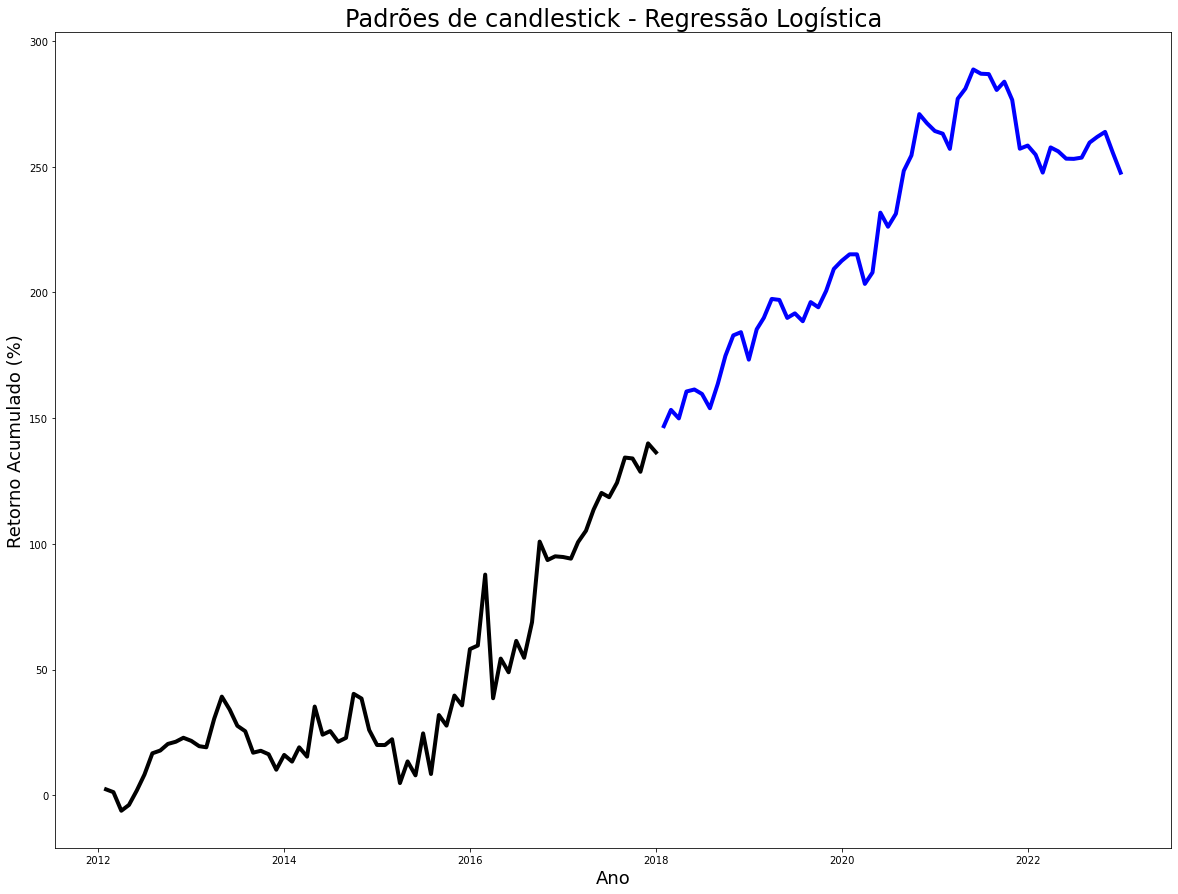

In [190]:
# Plota o gráfico
fig, ax = plt.subplots(figsize = (20, 15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c = color, linewidth = lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("Padrões de candlestick - Regressão Logística", fontsize = 24)
    #plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)



In [191]:
summary = df_padroes.copy()
summary["Data"] = pd.to_datetime(summary["Data"], format = "%Y-%m")

summary = summary.groupby([summary["Data"].dt.year]).agg({"Retorno_Modelo": sum})

summary.index = summary.index.set_names(["Ano"])

summary*100

,Retorno_Modelo
Ano,
2012,21.638490
2013,-5.591868
2014,3.953297
2015,38.139162
2016,36.635803
2017,41.619382
2018,36.881008
2019,39.314650
2020,51.636331


In [192]:
base_agregada.tail()

,Alvo1_cat,Alvo1,doji_star,harami,marubozu,engolfo,martelo,Previsto,Sinal,Retorno_Modelo,train_test,Retorno_Modelo_Acumulado
Data,,,,,,,,,,,,
2022-08-31,5,0.109993,0,-1,0,0,0,-1,-1,0.059661,5,259.606665
2022-09-30,2,0.011530,0,0,0,0,1,1,1,0.022742,3,261.880895
2022-10-31,1,-0.002225,0,-1,-1,-2,0,2,2,0.019974,4,263.878320
2022-11-30,4,-0.077471,0,2,-1,-3,0,4,4,-0.081745,8,255.703812
2022-12-31,2,-0.080063,0,1,-2,-2,0,5,5,-0.080563,5,247.647504
